In [1]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()


Successfully saved authorization token.


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_doiqkQG3NJ1t8IS?source=API


In [18]:
import ee

In [12]:
import os
import pandas as pd
import sys

In [3]:
from utils_pygee import *

In [40]:
from importlib import reload
reload(sys.modules['utils_pygee'])
from utils_pygee import *

# Functions

In [340]:
def ee_array_to_df(arr, list_of_bands):
    """
    Transforms client-side ee.Image.getRegion array to pandas.DataFrame.
    """
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [341]:
def mask_bits(image_qa, fromBit, toBit):
    def bitwiseExtract(value, fromBit, toBit):
        # if (toBit == frombit):
        #     toBit = fromBit
        maskSize = ee.Number(1).add(toBit).subtract(fromBit)
        mask = ee.Number(1).leftShift(maskSize).subtract(1)
        return value.rightShift(fromBit).bitwiseAnd(mask)
    good_qa = bitwiseExtract(image_qa, fromBit, toBit)
    return image_qa.updateMask(good_qa)

In [342]:
def QAfilter(image, QA_band, fromBit, toBit):
    #quality band 
    qaband = image.select(QA_band)
    #good quality image
    good = mask_bits(qaband, fromBit, toBit)
    return image.updateMask(good)
    

In [343]:
def mask_noncrop(image):
    """
    Masks non-crop pixels from the input imag using the MODIS landcover dataset.
    https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD12Q1
    """
    year = image.date().get('year')
    year = ee.Number(image.date().get('year')).max(2001).min(2022) # The landcover dataset is 2001-2022

    landcover_collection = ee.ImageCollection('MODIS/061/MCD12Q1').select('LC_Type1')
    landcover = landcover_collection.filter(ee.Filter.calendarRange(year, year, 'year')).first()
    
    #crop_mask = landcover.gte(12).And(landcover.lte(14))
    crop_mask = landcover.eq(12) 
    return image.updateMask(crop_mask)

In [344]:
# Function to mask cloudy pixels for MCD43A4
def maskClouds_MODIS_Ref(image):
    qa = image.select('Nadir_Reflectance_Band1').select('SummaryQA')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask)

In [345]:
# Function to mask cloudy pixels for MCD15A3H
def maskClouds_MODIS_LAI(image):
    qa = image.select('Lai_500m').select('FparLai_QC')
    cloudBitMask = 1 << 0
    mask = qa.bitwiseAnd(cloudBitMask).eq(0)
    return image.updateMask(mask)

In [346]:
# Function to calculate NDVI for MCD43A4
def addNDVI_MODIS(image):
    ndvi = image.normalizedDifference(['Nadir_Reflectance_Band2', 'Nadir_Reflectance_Band1']).rename('NDVI')
    return image.addBands(ndvi)
# Function to calculate EVI for MCD43A4
def addEVI_MODIS(image):
    evi = image.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': image.select('Nadir_Reflectance_Band2'),
        'RED': image.select('Nadir_Reflectance_Band1'),
        'BLUE': image.select('Nadir_Reflectance_Band3')
    }).rename('EVI')
    return image.addBands(evi)

In [347]:
# Extract time series data
def extract_time_series(image, aoi, var):
    image = image.select(var)
    mean_var = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi, scale=500)
    return ee.Feature(None, {'date': image.date().format(), 'mean_{}'.format(var): mean_var.get(var)})

In [348]:
# Convert time series data to pandas dataframe
def eets_to_df(eets_dict, var):
    features = eets_dict['features']
    dates = []
    mean_var = []
    for feature in features:
        properties = feature['properties']
        date = properties.get('date', None)
        mean = properties.get('mean_{}'.format(var), None)
        # Only append to lists if date and mean are not None
        if date:
            dates.append(date)
            mean_var.append(mean if mean is not None else float('NaN'))
    df = pd.DataFrame({'date': dates, 'mean_{}'.format(var): mean_var})
    # Scale the mean_var if var is Lai or Fpar
    if var == 'Lai':
        df['mean_{}'.format(var)] = df['mean_{}'.format(var)] * 0.1
    if var == 'Fpar':
        df['mean_{}'.format(var)] = df['mean_{}'.format(var)] * 0.01
    
    return df

In [349]:
# Aggregate time series data to a longer time interval, e.g. monthly, using pandas 
def agg_ts(df, freq='1M'):
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df = df.resample(freq).median()
    df = df.reset_index()
    return df

In [350]:
def generate_ts_df(image_collection, aoi, var, freq='1M', Output=False, dir_out=None, aoi_name=None):
    """
    Generate time series data for a given image collection, aoi, and variable.
    """
    var_ee = ee.String(var)
    freq_ee = ee.String(freq)
    
    eets = image_collection.map(lambda image: extract_time_series(image, aoi, var_ee))
    
    if Output:
        # If aoi_name is not provided as an argument, then fetch it
        if not aoi_name:
            aoi_name = aoi.getInfo()['features'][0]['properties']['NAME']
        
        # Fetch both dates in a single call to getInfo()
        date_range = ee.Dictionary({
            'start': ee.Date(image_collection.first().get('system:time_start')).format('YYYYMM'),
            'end': ee.Date(image_collection.sort('system:time_end', False).first().get('system:time_end')).format('YYYYMM')
        }).getInfo()
        
        sdate = date_range['start']
        edate = date_range['end']
        
        eets_dict = eets.getInfo()
        df = eets_to_df(eets_dict, var)
        df = agg_ts(df, freq)
        df['Month'] = df['date'].dt.month
        df['Year'] = df['date'].dt.year
        
        out_name = '{}_{}_{}_{}_{}.csv'.format(aoi_name, var, sdate, edate, freq)
        df.to_csv(os.path.join(dir_out, out_name), index=False)
        return df
    else:
        return eets


In [353]:
def generate_ts_df(image_collection, aoi, var, freq='1M', Output = False, dir_out = None):
    """
    Generate time series data for a given image collection, aoi, and variable.
    """
    # var_ee = ee.String(var)
    # aoi = aoi.geometry()
    
    freq_ee = ee.String(freq)
    eets = image_collection.map(lambda image: extract_time_series(image, aoi, var))
    eets_dict = eets.getInfo()
    df = eets_to_df(eets_dict, var)
    df = agg_ts(df, freq)
    df['Month'] = df['date'].dt.month
    df['Year'] = df['date'].dt.year

    # Output name 
    aoi_name = aoi.getInfo()['features'][0]['properties']['NAME']
    sdate = df['date'].min().strftime('%Y%m')
    edate = df['date'].max().strftime('%Y%m')
    out_name = '{}_{}_{}_{}_{}.csv'.format(aoi_name, var, sdate, edate, freq)
    if Output:
        df.to_csv(os.path.join(dir_out, out_name), index=False)
    return df

In [351]:
def agg_eets(collection, interval_type, value=30):
    # Calculate the start and end dates of the collection
    start_date = ee.Date(collection.first().get('system:time_start'))
    end_date = ee.Date(collection.sort('system:time_start', False).first().get('system:time_start'))

    if interval_type == "days":
        # Create a list of start times for each interval based on days
        range_list = ee.List.sequence(0, end_date.difference(start_date, 'day'), value)

        def aggregate_by_day_interval(n):
            start = start_date.advance(n, 'day')
            end = start.advance(value, 'day')
            interval_images = collection.filterDate(start, end)
            return interval_images.mean().set('start_date', start).set('end_date', end)

        return range_list.map(aggregate_by_day_interval)

    elif interval_type == "months":
        # Create a list of start months for each interval
        num_months = end_date.difference(start_date, 'month').round()
        range_list = ee.List.sequence(0, num_months.subtract(1))

        def aggregate_by_month(n):
            start = start_date.advance(n, 'month')
            end = start.advance(1, 'month')
            interval_images = collection.filterDate(start, end)
            return interval_images.mean().set('start_date', start).set('end_date', end)

        return range_list.map(aggregate_by_month)

    else:
        raise ValueError("Invalid interval_type. Choose 'days' or 'months'.")

# Parameters

In [4]:
States = ee.FeatureCollection("TIGER/2018/States")
US_States = States.filter(ee.Filter.inList('NAME', ['North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Iowa', 'Missouri', 'Illinois', 'Indiana', 'Ohio']))
#US_States = States.filter(ee.Filter.inList('NAME', ['North Dakota', 'South Dakota']))

In [5]:
state = US_States.filter(ee.Filter.eq('NAME', 'Illinois'))
# Define a small rectangle within Illinois for testing
test_region = ee.Geometry.Rectangle([-89.5, 39.5, -88.5, 40.5])  # Define the rectangle by [minLon, minLat, maxLon, maxLat]

In [50]:
# start end date
start_date = '2023-01-01'
end_date = '2023-10-01'

# Dataset

In [51]:
#https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD15A3H
FparLai_collection = (ee.ImageCollection('MODIS/061/MCD15A3H')
                  .filterDate(ee.Date(start_date), ee.Date(end_date)))

In [52]:
#https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD13A3
modis_collection = (ee.ImageCollection('MODIS/061/MCD43A4')
                     .filterDate(ee.Date(start_date), ee.Date(end_date)))

In [53]:
cfsv2_collection = (ee.ImageCollection('NOAA/CFSV2/FOR6H')
                        .filterDate(ee.Date(start_date), ee.Date(end_date)))

# Preprocess

## Apply Non-crop mask

In [54]:
FparLai_masked = FparLai_collection.map(mask_noncrop)
FparLai_filtered = FparLai_masked.map(lambda image: QAfilter(image, 'FparLai_QC', 0, 0))

In [55]:
modis_masked = modis_collection.map(mask_noncrop)
modis_filtered = modis_masked.map(lambda image: QAfilter(image, 'BRDF_Albedo_Band_Mandatory_Quality_Band1', 0, 0))

In [56]:
cfsv2_masked = cfsv2_collection.map(mask_noncrop)
cfsv2_filtered = cfsv2_masked # There is no quality band for CFSV2

## Add VIs

In [57]:
modis_filtered = modis_filtered.map(addNDVI_MODIS)
modis_filtered = modis_filtered.map(addEVI_MODIS)

# Extract time series

## CFSV2

In [58]:
State_list = ['North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Iowa', 'Missouri', 'Illinois', 'Indiana', 'Ohio']
for state in State_list:
    print("--------------------{}--------------------".format(state))
    aoi = States.filter(ee.Filter.eq('NAME', state))
    generate_ts_df(cfsv2_filtered, aoi, 'Maximum_temperature_height_above_ground_6_Hour_Interval', freq='1M', func= "median",Output=True, dir_out=r"A:\US_CornSoy_ClassificationYield\GEEData\State_Monitor")
    print("Tmax done")
    generate_ts_df(cfsv2_filtered, aoi, 'Minimum_temperature_height_above_ground_6_Hour_Interval', freq='1M', func = "median",Output=True, dir_out=r"A:\US_CornSoy_ClassificationYield\GEEData\State_Monitor")
    print("Tmin done")
    generate_ts_df(cfsv2_filtered, aoi, 'Volumetric_Soil_Moisture_Content_depth_below_surface_layer_5_cm', freq='1M', func = "median",Output=True, dir_out=r"A:\US_CornSoy_ClassificationYield\GEEData\State_Monitor")
    print("Soil Moisture 5cm done")
    generate_ts_df(cfsv2_filtered, aoi, 'Volumetric_Soil_Moisture_Content_depth_below_surface_layer_25_cm', freq='1M',func = "median", Output=True, dir_out=r"A:\US_CornSoy_ClassificationYield\GEEData\State_Monitor")
    print("Soil Moisture 25cm done")
    generate_ts_df(cfsv2_filtered, aoi, 'Precipitation_rate_surface_6_Hour_Average', freq='1M', func = "sum",Output=True, dir_out=r"A:\US_CornSoy_ClassificationYield\GEEData\State_Monitor")
    print("Precipitation done")
    

--------------------North Dakota--------------------
--------------------South Dakota--------------------
--------------------Nebraska--------------------
--------------------Kansas--------------------
--------------------Iowa--------------------
--------------------Missouri--------------------
--------------------Illinois--------------------
--------------------Indiana--------------------
--------------------Ohio--------------------


## LAI

In [361]:
State_list = ['North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Iowa', 'Missouri', 'Illinois', 'Indiana', 'Ohio']
for state in State_list:
    print("--------------------{}--------------------".format(state))
    aoi = States.filter(ee.Filter.eq('NAME', state))
    # df_test = generate_ts_df(FparLai_filtered, aoi, 'Fpar', freq='1M', Output = True, dir_out = r"A:\US_CornSoy_ClassificationYield\GEEData")
    # print('Fpar done')
    # df_test = generate_ts_df(FparLai_filtered, aoi, 'Lai', freq='1M', Output = True, dir_out = r"A:\US_CornSoy_ClassificationYield\GEEData")
    # print('Lai done')
    df_test = generate_ts_df(modis_filtered, aoi, 'NDVI', freq='1M', Output = True, dir_out = r"A:\US_CornSoy_ClassificationYield\GEEData")
    print('NDVI done')
    df_test = generate_ts_df(modis_filtered, aoi, 'EVI', freq='1M', Output = True, dir_out = r"A:\US_CornSoy_ClassificationYield\GEEData")
    print('EVI done')

--------------------North Dakota--------------------
NDVI done
EVI done
--------------------South Dakota--------------------
NDVI done
EVI done
--------------------Nebraska--------------------
NDVI done
EVI done
--------------------Kansas--------------------
NDVI done
EVI done
--------------------Iowa--------------------
NDVI done
EVI done
--------------------Missouri--------------------
NDVI done
EVI done
--------------------Illinois--------------------
NDVI done
EVI done
--------------------Indiana--------------------
NDVI done
EVI done
--------------------Ohio--------------------
NDVI done
EVI done


In [211]:
ts_lai = FparLai_filtered.map(lambda image: extract_time_series(image, state, 'Lai'))
ts_lai_dict = ts_lai.getInfo()
df_lai = eets_to_df(ts_lai_dict, 'Lai')

# Aggregate to monthly
df_lai_monthly = agg_ts(df_lai, freq='1M')
df_lai_monthly['Month'] = df_lai_monthly['date'].dt.month
df_lai_monthly['Year'] = df_lai_monthly['date'].dt.year
df_lai_monthly.head()

,date,mean_Lai,Month,Year
0,2022-01-31,0.020946,1,2022
1,2022-02-28,0.023163,2,2022
2,2022-03-31,0.159117,3,2022
3,2022-04-30,0.315208,4,2022
4,2022-05-31,0.919224,5,2022


<AxesSubplot:xlabel='date'>

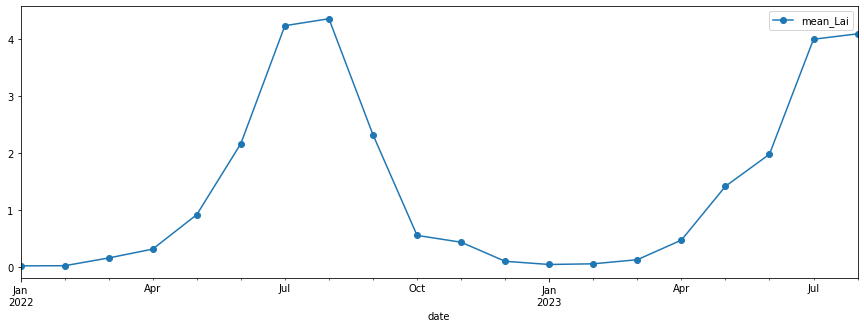

In [212]:
# Plot the time series, with both points and lines
df_lai_monthly.plot(x='date', y='mean_Lai', marker='o', linestyle='-', figsize=(15, 5))

## Fpar

In [203]:
ts_fpar = FparLai_filtered.map(lambda image: extract_time_series(image, test_region, 'Fpar'))
ts_fpar_dict = ts_fpar.getInfo()
df_fpar = eets_to_df(ts_fpar_dict, 'Fpar')

# Aggregate to monthly
df_fpar_monthly = agg_ts(df_fpar, freq='1M')
df_fpar_monthly['Month'] = df_fpar_monthly['date'].dt.month
df_fpar_monthly['Year'] = df_fpar_monthly['date'].dt.year
df_fpar_monthly.head()

,date,mean_Fpar,Month,Year
0,2022-01-31,0.096019,1,2022
1,2022-02-28,0.009719,2,2022
2,2022-03-31,0.215755,3,2022
3,2022-04-30,0.201348,4,2022
4,2022-05-31,0.526259,5,2022


<AxesSubplot:xlabel='date'>

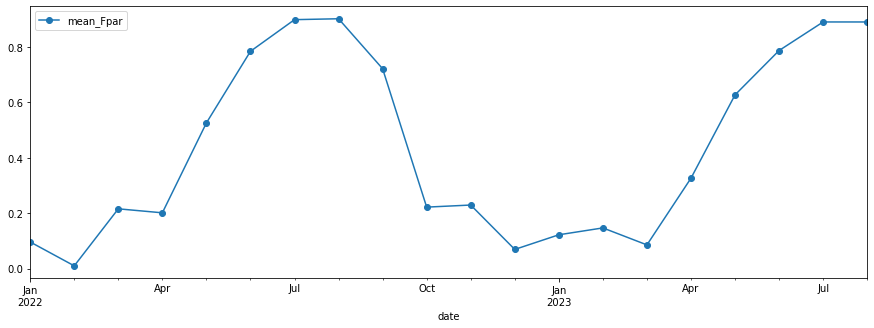

In [204]:
df_fpar_monthly.plot(x='date', y='mean_Fpar', marker='o', linestyle='-', figsize=(15, 5))

## NDVI

In [216]:
ts_ndvi = modis_filtered.map(lambda image: extract_time_series(image, Illinois, 'NDVI'))
ts_ndvi_dict = ts_ndvi.getInfo()
df_ndvi = eets_to_df(ts_ndvi_dict, 'NDVI')

# Aggregate to monthly
df_ndvi_monthly = agg_ts(df_ndvi, freq='1M')
df_ndvi_monthly['Month'] = df_ndvi_monthly['date'].dt.month
df_ndvi_monthly['Year'] = df_ndvi_monthly['date'].dt.year
df_ndvi_monthly.head()

,date,mean_NDVI,Month,Year
0,2022-01-31,0.148039,1,2022
1,2022-02-28,0.086588,2,2022
2,2022-03-31,0.275831,3,2022
3,2022-04-30,0.347806,4,2022
4,2022-05-31,0.405622,5,2022


<AxesSubplot:xlabel='date'>

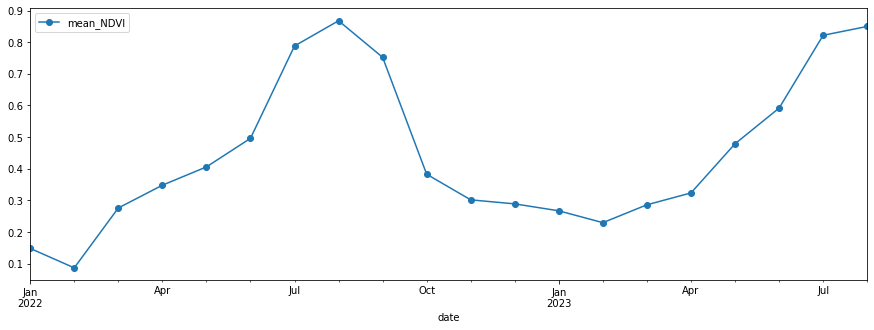

In [217]:
df_ndvi_monthly.plot(x='date', y='mean_NDVI', marker='o', linestyle='-', figsize=(15, 5))

## EVI

In [220]:
evi_agg = agg_eets(modis_filtered, 'months')

In [222]:
tsagg_evi = modis_filtered.map(lambda image: extract_time_series(image, Illinois, 'EVI'))
tsagg_evi_dict = tsagg_evi.getInfo()

In [224]:
df_eviagg = eets_to_df(tsagg_evi_dict, 'EVI')
df_eviagg

,date,mean_EVI
0,2022-01-01T00:00:00,0.328631
1,2022-01-02T00:00:00,0.367173
2,2022-01-03T00:00:00,0.339480
3,2022-01-04T00:00:00,0.222999
4,2022-01-05T00:00:00,0.196095
...,...,...
603,2023-08-27T00:00:00,1.545445
604,2023-08-28T00:00:00,1.595288
605,2023-08-29T00:00:00,1.600303
606,2023-08-30T00:00:00,1.651021


In [226]:
ts_evi = modis_filtered.map(lambda image: extract_time_series(image, test_region, 'EVI'))
ts_evi_dict = ts_evi.getInfo()
df_evi = eets_to_df(ts_evi_dict, 'EVI')

# Aggregate to monthly
df_evi_monthly = agg_ts(df_evi, freq='1M')
df_evi_monthly['Month'] = df_evi_monthly['date'].dt.month
df_evi_monthly['Year'] = df_evi_monthly['date'].dt.year
df_evi_monthly.head()

,date,mean_EVI,Month,Year
0,2022-01-31,0.486061,1,2022
1,2022-02-28,0.184148,2,2022
2,2022-03-31,0.463514,3,2022
3,2022-04-30,0.585905,4,2022
4,2022-05-31,0.658583,5,2022


In [ ]:
df_evi_monthly

# Output 